## Dependencies

### Install following (if not already available in docker container)

```
apt-get install ffmpeg libsm6 libxext6  -y
```

### Install python wrapper

```
pip install opencv-contrib-python
```

### Install OCR package

```
apt install tesseract-ocr
pip install pytesserat
```

### Install 7 segment trained data

Derived from: git clone https://github.com/Shreeshrii/tessdata_ssd
```
cp trained_data/7seg.traineddata /usr/share/tesseract-ocr/4.00/tessdata
cp trained_data/ssd.traineddata /usr/share/tesseract-ocr/4.00/tessdata
cp trained_data/ssd_int.traineddata /usr/share/tesseract-ocr/4.00/tessdata
```
Note: 7seg seems to be best for LCD display.


In [1]:
import cv2
import numpy as np
import pytesseract

from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (8.0, 6.0) # this controls figure size in the notebook

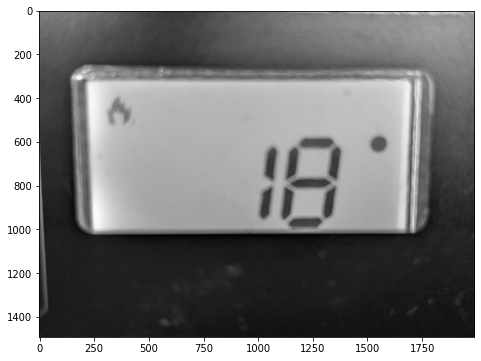

In [2]:
original = cv2.imread('./images/LCD_heating_18.jpeg')
gray = cv2.imread('./images/LCD_heating_18.jpeg', cv2.IMREAD_GRAYSCALE) # Load LCD image

plt.imshow(gray, cmap='gray')

In [3]:
thresh_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

cnts = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for cnt in cnts:
    approx = cv2.contourArea(cnt)
    print(approx)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5
9.5
2.5
3.0
0.0
2.5
0.0
0.5
0.0
0.0
1.0
0.0
9.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
377.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
230.5
0.0
0.0
0.0
0.5
29.0
0.0
0.0
0.0
36.0
4.5
0.0
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3875.0
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.5
0.0
0.0
0.0
0.0
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0
0.0
0.0
0.5
0.0
0.0
0.0
0.0
0.0
0.0
1.5
2.5
0.0
0.0
0.0
0.0
0.0
1.5
0.0
0.0
0.0
0.0
0.0
0.0
10.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5
0.0
0.0
4.5
6.0
0.0
0.0
1.5
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
2.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
12.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
14.0
0.0
0.5
0.0


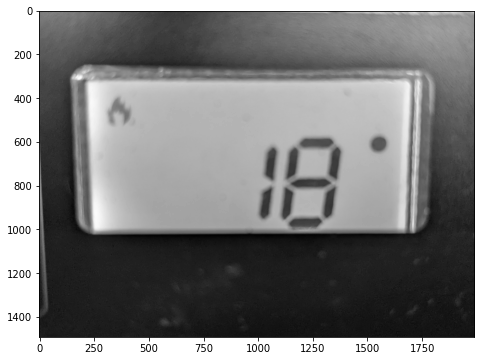

In [4]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

plt.imshow(blurred, cmap='gray')

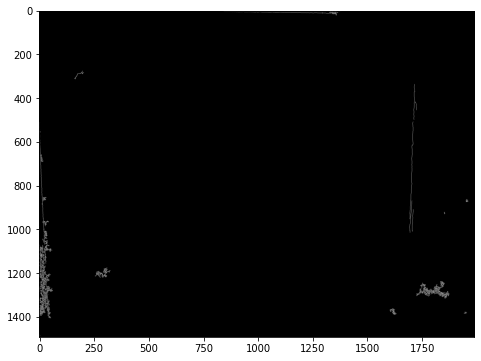

In [5]:
edges = cv2.Canny(gray, 0, 255, True) # edge detection

plt.imshow(edges, cmap='gray')

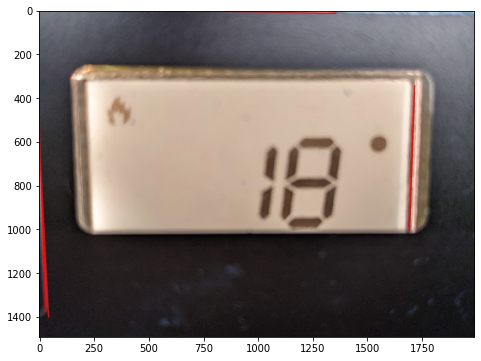

In [6]:
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 150, minLineLength=10, maxLineGap=250) # hough transform

# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(original, (x1, y1), (x2, y2), (255, 0, 0), 3)
    
plt.imshow(original, cmap='gray')

In [61]:
is_normalized = False

# Load an image using 'imread' specifying the path to image
image = cv2.imread('./assets/images/LCD_heating_18.jpeg')

# Set total number of bins in the histogram
bins_num = 256

# Get the image histogram
hist, bin_edges = np.histogram(image, bins=bins_num)

# Get normalized histogram if it is required
if is_normalized:
    hist = np.divide(hist.ravel(), hist.max())

# Calculate centers of bins
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

# Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

# Get the class means mu0(t)
mean1 = np.cumsum(hist * bin_mids) / weight1
# Get the class means mu1(t)
mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

# Maximize the inter_class_variance function val
index_of_max_val = np.argmax(inter_class_variance)

threshold = bin_mids[:-1][index_of_max_val]
print("Otsu's algorithm implementation thresholding result: ", threshold)

Otsu's algorithm implementation thresholding result:  109.072265625


18



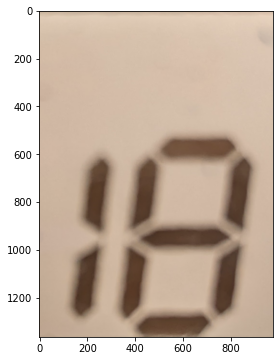

In [8]:
input_image = cv2.imread('./images/LCD_heating_18_segmented.jpeg')

plt.imshow(input_image)

# Cvt to hsv
hsv = cv2.cvtColor(input_image, cv2.COLOR_BGR2HSV)

# Get binary-mask
msk = cv2.inRange(hsv, np.array([0, 0, 175]), np.array([179, 255, 255]))
krn = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
dlt = cv2.dilate(msk, krn, iterations=1)
thr = 255 - cv2.bitwise_and(dlt, msk)

# OCR
d = pytesseract.image_to_string(thr, config="-l 7seg --psm 8") # best
#d = pytesseract.image_to_string(thr, config="-l ssd_int --psm 8")
#d = pytesseract.image_to_string(thr, config="-l 7seg --psm 8")
print(d)